#Library

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import os
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import category_encoders as ce
import missingno as mn
import lightgbm as ltb
from sklearn.ensemble import ExtraTreesRegressor
random.seed(0)

#Data describe

In [ ]:
train = pd.read_csv("/content/train.csv", sep=";")
train.head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,First Owner,21.5 kmpl,1497 CC,108.5 bhp,260Nm@ 1500-2750rpm,5.0
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,First Owner,21.19 kmpl,1396 CC,88.76 bhp,219.66nm@ 1500-2750rpm,5.0
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,Second Owner,12.55 kmpl,2982 CC,168.5 bhp,360Nm@ 1400-3200rpm,7.0


In [ ]:
test = pd.read_csv("/content/test.csv", sep=";")
test.head(3)

,Id,name,year,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,1,Skoda Rapid 1.6 MPI AT Elegance,2016,11000,Petrol,Dealer,Automatic,First Owner,14.3 kmpl,1598 CC,103.5 bhp,153Nm@ 3800rpm,5.0
1,2,Honda City i VTEC V,2017,35000,Petrol,Individual,Manual,First Owner,17.8 kmpl,1497 CC,117.3 bhp,145Nm@ 4600rpm,5.0
2,3,Hyundai Xcent 1.2 Kappa SX Option,2014,80000,Petrol,Individual,Manual,First Owner,19.1 kmpl,1197 CC,82 bhp,114Nm@ 4000rpm,5.0


In [ ]:
print(train.shape)
print(test.shape)

(6000, 13)
(2128, 13)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6000 non-null   object 
 1   year           6000 non-null   int64  
 2   selling_price  6000 non-null   int64  
 3   km_driven      6000 non-null   int64  
 4   fuel           6000 non-null   object 
 5   seller_type    6000 non-null   object 
 6   transmission   6000 non-null   object 
 7   owner          6000 non-null   object 
 8   mileage        5841 non-null   object 
 9   engine         5841 non-null   object 
 10  max_power      5846 non-null   object 
 11  torque         5840 non-null   object 
 12  seats          5841 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 609.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128 entries, 0 to 2127
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            2128 non-null   int64  
 1   name          2128 non-null   object 
 2   year          2128 non-null   int64  
 3   km_driven     2128 non-null   int64  
 4   fuel          2128 non-null   object 
 5   seller_type   2128 non-null   object 
 6   transmission  2128 non-null   object 
 7   owner         2128 non-null   object 
 8   mileage       2066 non-null   object 
 9   engine        2066 non-null   object 
 10  max_power     2067 non-null   object 
 11  torque        2066 non-null   object 
 12  seats         2066 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 216.2+ KB


In [ ]:
train.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          159
engine           159
max_power        154
torque           160
seats            159
dtype: int64

In [ ]:
test.isnull().sum()

Id               0
name             0
year             0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage         62
engine          62
max_power       61
torque          62
seats           62
dtype: int64

#EDA

In [ ]:
def encode(train):
  # # Encode Fuel Data
  # train['fuel']= train['fuel'].replace({'Diesel': 0, 'Petrol': 1, 'CNG': 2, 'LPG': 2})
  # train['fuel']= train['fuel'].replace({'CNG': "Gas", 'LPG': "Gas"})

  # # Encode Transmission Data
  # train['transmission']= train['transmission'].replace({'Manual': 0, 'Automatic': 1})

  # # Encode Seller Type Data
  # train['seller_type']= train['seller_type'].replace({'Individual': 0, 'Dealer': 1, 'Trustmark Dealer': 2})

  # #Encoding owner data
  train['owner'] = train['owner'].replace({'First Owner': 1, 'Second Owner': 2, 'Third Owner': 3, 'Fourth & Above Owner': 4, 'Test Drive Car': 0})
  # train['owner'] = train['owner'].replace({'Test Drive Car': 'First Owner'})

  train['mi'] = train[train.mileage.notnull()].mileage.apply(lambda x: x.split(" ")[1])


  train['mileage']= train['mileage'].replace(' kmpl','', regex=True).str.replace(',', '')
  train['mileage']= train['mileage'].replace(' km/kg','',regex=True).str.replace(',', '')
  train['engine']= train['engine'].replace(' CC','',regex=True).str.replace(',', '')
  train['max_power']= train['max_power'].replace(' bhp','',regex=True).str.replace(',', '')

  train['mileage'] = pd.to_numeric(train['mileage'])
  train['engine'] = pd.to_numeric(train['engine'])
  train['max_power'] = pd.to_numeric(train['max_power'])

  for i in range(train.shape[0]):
    if train['mi'].iloc[i] == 'km/kg':
      train.at[i, 'mileage'] = train.at[i, 'mileage'] * 1.4
      
  for i in range(train.shape[0]):
    train.at[i, 'Company'] = train['name'][i].split()[0]


In [ ]:
encode(train)
encode(test)

In [ ]:
import re

def torque_processing(torque):
#     fix here if error
    if type(torque) == int and torque == 0:
        return 0,0
#     -----------
    element = torque.split()
    power = []
    for e in element:
        tor = re.findall("(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", e)
        power.append(tor)
    power = [tor for tor in power if tor]
    if 'kgm@' in torque:
        # 1kgm@ = 10nm
        power[0] = round(float(power[0][0]) * 10, 1)
    else:
        power[0] = round(float(power[0][0]), 1)
    if len(power) == 2:
        if len(power[1]) == 2:
            power[1] = round(np.mean([float(i) for i in power[1]]), 1)
        else:
            power[1] = round(float(power[1][0]), 1)
    if len(power) == 1:
        power.append(None)
    if power[1] < 1000:
    # print('SMALLER THAN 1000',power[1])
        power[1] = round(power[1] * 1000, 1)
    return power[0], power[1]

In [ ]:
train['torque'] = train['torque'].str.replace(',','.')
for i in range(train.shape[0]):
  try:
    torque, rpm = torque_processing(train['torque'].iloc[i])
    train.at[i, 'torque_'] = torque
    train.at[i, 'rpm'] = rpm
  except:
    pass


In [ ]:
test['torque'] = test['torque'].str.replace(',','.')
for i in range(test.shape[0]):
  try:
    torque, rpm = torque_processing(test['torque'].iloc[i])
    test.at[i, 'torque_'] = torque
    test.at[i, 'rpm'] = rpm
  except:
    pass


In [ ]:
train.drop(5537,inplace=True)

In [ ]:
train.head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mi,Company,torque_,rpm
0,Tata Nexon 1.5 Revotorq XM,2018,850000,9500,Diesel,Individual,Manual,1,21.50,1497.0,108.50,260Nm@ 1500-2750rpm,5.0,kmpl,Tata,260.0,2125.0
1,Hyundai i20 Active SX Diesel,2018,750000,30000,Diesel,Individual,Manual,1,21.19,1396.0,88.76,219.66nm@ 1500-2750rpm,5.0,kmpl,Hyundai,219.7,2125.0
2,Toyota Fortuner 4x2 AT,2015,1500000,80000,Diesel,Individual,Automatic,2,12.55,2982.0,168.50,360Nm@ 1400-3200rpm,7.0,kmpl,Toyota,360.0,2300.0


In [ ]:
train.drop(["name","torque",'mi'],axis=1, inplace = True)
test.drop(["name","torque",'mi'],axis=1, inplace = True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5999 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           5999 non-null   int64  
 1   selling_price  5999 non-null   int64  
 2   km_driven      5999 non-null   int64  
 3   fuel           5999 non-null   object 
 4   seller_type    5999 non-null   object 
 5   transmission   5999 non-null   object 
 6   owner          5999 non-null   int64  
 7   mileage        5840 non-null   float64
 8   engine         5840 non-null   float64
 9   max_power      5844 non-null   float64
 10  seats          5840 non-null   float64
 11  Company        5999 non-null   object 
 12  torque_        5815 non-null   float64
 13  rpm            5815 non-null   float64
dtypes: float64(6), int64(4), object(4)
memory usage: 703.0+ KB


In [ ]:
train.describe()

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats,torque_,rpm
count,5999.000000,5.999000e+03,5.999000e+03,5999.000000,5840.000000,5840.000000,5844.000000,5840.000000,5815.000000,5815.000000
mean,2013.814302,6.372159e+05,6.997882e+04,1.456409,19.485221,1464.270548,91.532422,5.429795,179.302769,2920.366036
std,4.026859,7.976223e+05,5.189136e+04,0.711965,4.260546,508.319777,35.758824,0.976976,111.800338,3408.632053
min,1983.000000,3.000000e+04,1.000000e+03,0.000000,0.000000,624.000000,0.000000,2.000000,11.400000,1300.000000
25%,2011.000000,2.554995e+05,3.500000e+04,1.000000,16.780000,1197.000000,68.050000,5.000000,111.700000,2000.000000
50%,2015.000000,4.500000e+05,6.000000e+04,1.000000,19.300000,1248.000000,82.000000,5.000000,170.000000,2400.000000
75%,2017.000000,6.750000e+05,9.900000e+04,2.000000,22.320000,1582.000000,102.000000,5.000000,205.000000,4000.000000
max,2020.000000,6.523000e+06,1.500000e+06,4.000000,46.816000,3604.000000,282.000000,14.000000,1900.000000,251500.000000


#Visualize

In [ ]:
cmap=sns.diverging_palette(30, 225, n=200)

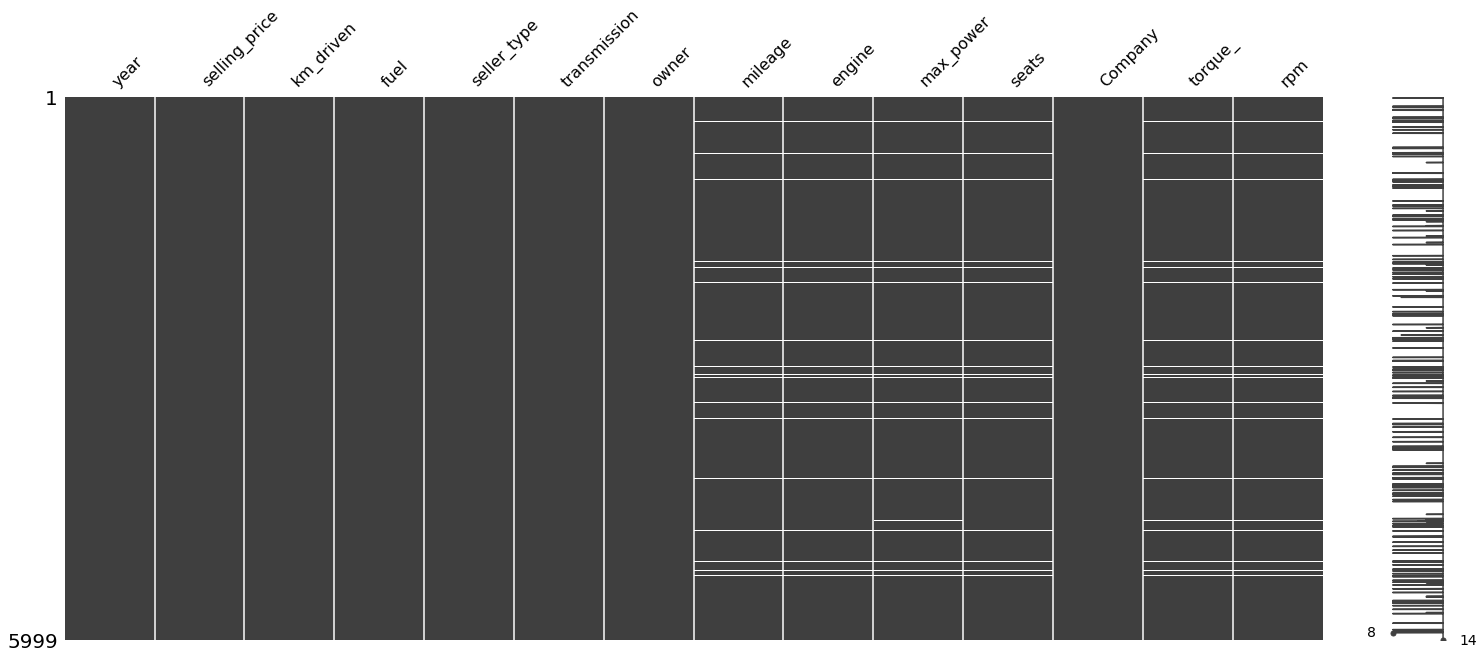

In [ ]:
mn.matrix(train)

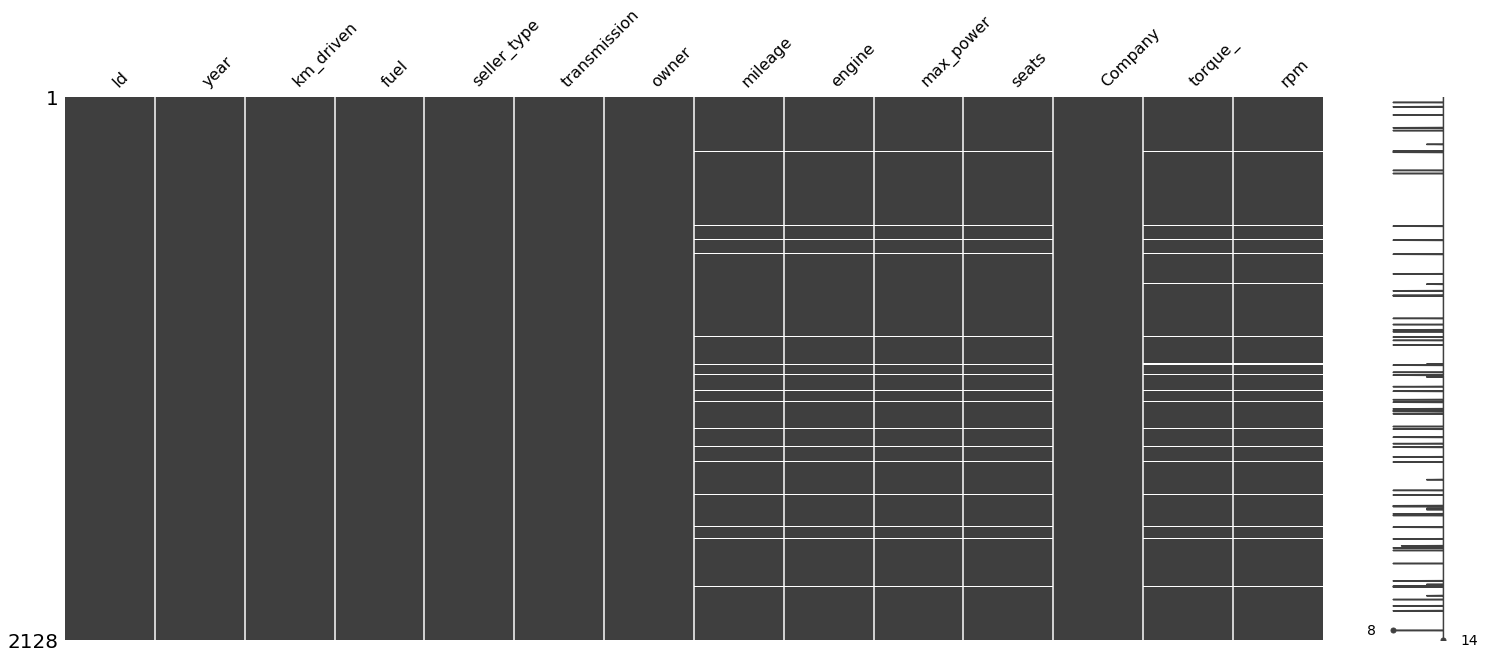

In [ ]:
mn.matrix(test)

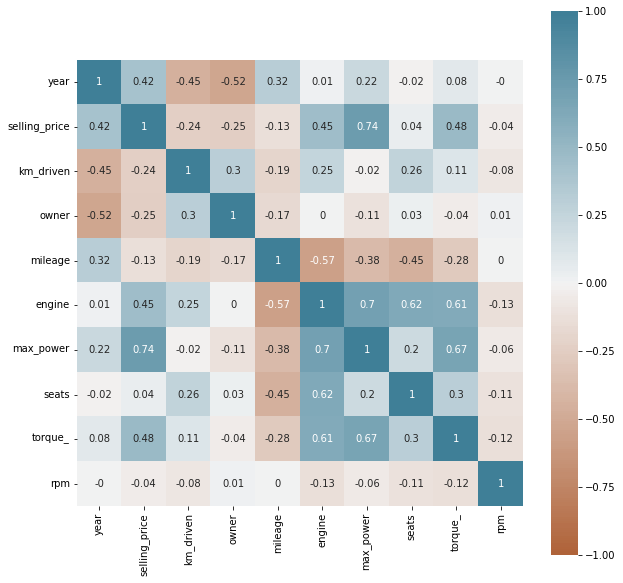

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))  
cor = train.corr(method='pearson').round(2)
sns.heatmap(cor,vmin=-1, vmax=1, center=0, cmap=cmap,
    square=True,ax=ax,
    annot=True)

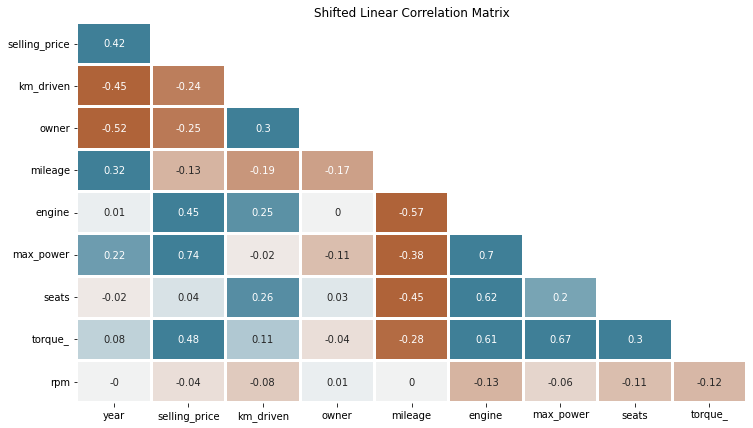

In [ ]:
''' Plot aa Shifted Correlation Matrix '''
#Đường chéo correl luôn thống nhất và ít liên quan hơn, các biến chuyển đổi
# chỉ hiển thị các trường hợp có liên quan
def corrMat(df,id=False):
    
    corr_mat = df.corr(method='pearson').round(2)
    f, ax = plt.subplots(figsize=(12,7))
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    mask = mask[1:,:-1]
    corr = corr_mat.iloc[1:,:-1].copy()
    sns.heatmap(corr,mask=mask,vmin=-0.3,vmax=0.3,center=0, 
                cmap=cmap,square=False,lw=2,annot=True,cbar=False)
#     bottom, top = ax.get_ylim() 
#     ax.set_ylim(bottom + 0.5, top - 0.5) 
    ax.set_title('Shifted Linear Correlation Matrix')
    
corrMat(train)

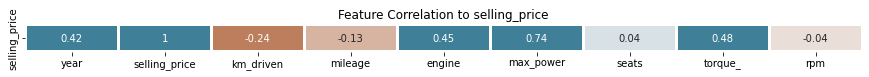

In [ ]:
'''Plot Correlation to Target Variable only'''
def corrMat2(df,target='selling_price',figsize=(15,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0, 
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')
    
    if(ret_id):
        return corr
corrMat2(train.drop(['fuel', 'seller_type', 'transmission', 'owner',"Company"],axis=1))

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


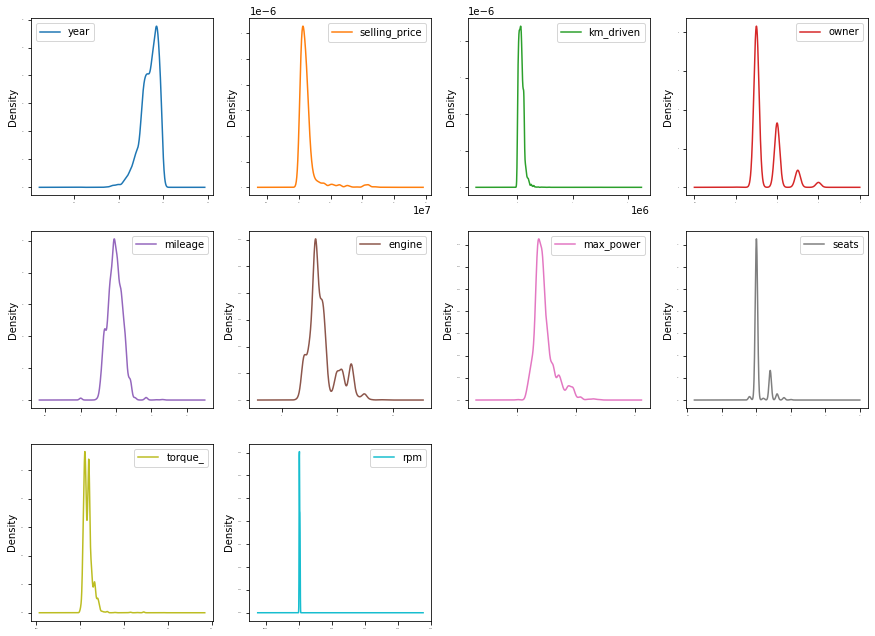

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
train.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=True, fontsize=1, ax=ax,)
plt.show()

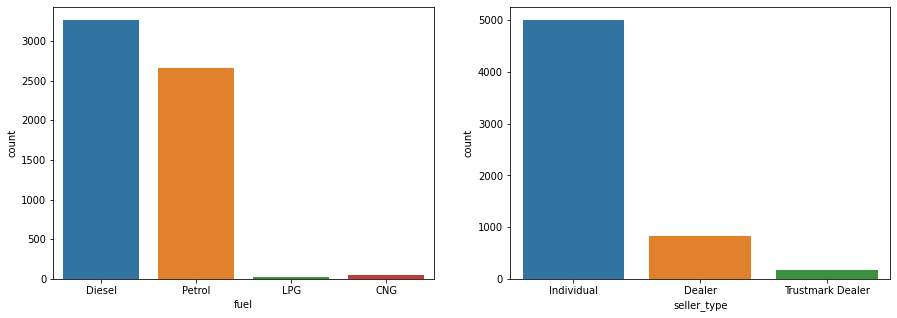

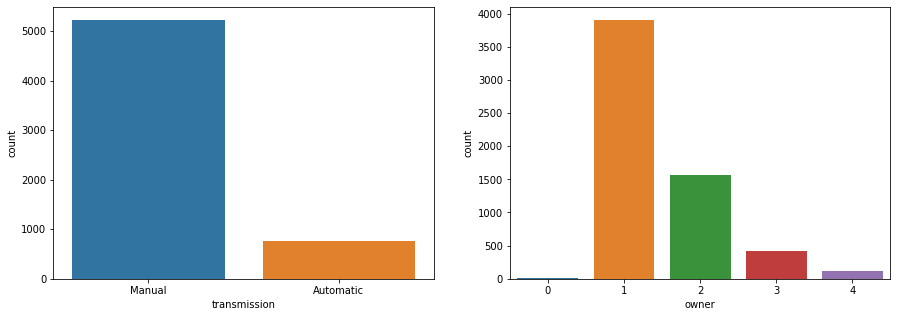

In [ ]:
cat_cols = ['fuel','seller_type','transmission','owner']
i=0
while i < 4:
    fig = plt.figure(figsize=[15,5])
    #ax1 = fig.add_subplot(121)
    #ax2 = fig.add_subplot(122)
    
    #ax1.title.set_text(cat_cols[i])
    plt.subplot(1,2,1)
    sns.countplot(x=cat_cols[i], data=train)
    i += 1
    
    #ax2.title.set_text(cat_cols[i])
    plt.subplot(1,2,2)
    sns.countplot(x=cat_cols[i], data=train)
    i += 1
    
    plt.show()

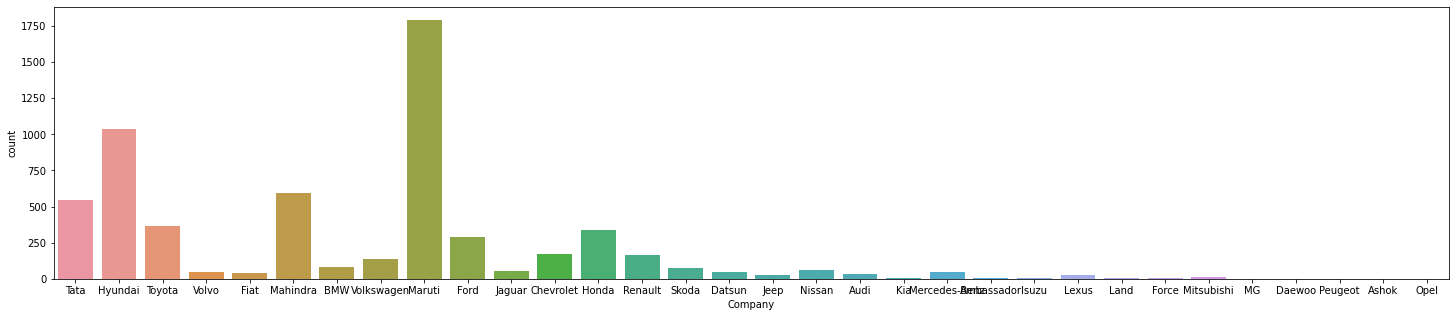

In [ ]:
plt.figure(figsize=[25,5])
sns.countplot(x="Company", data=train)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


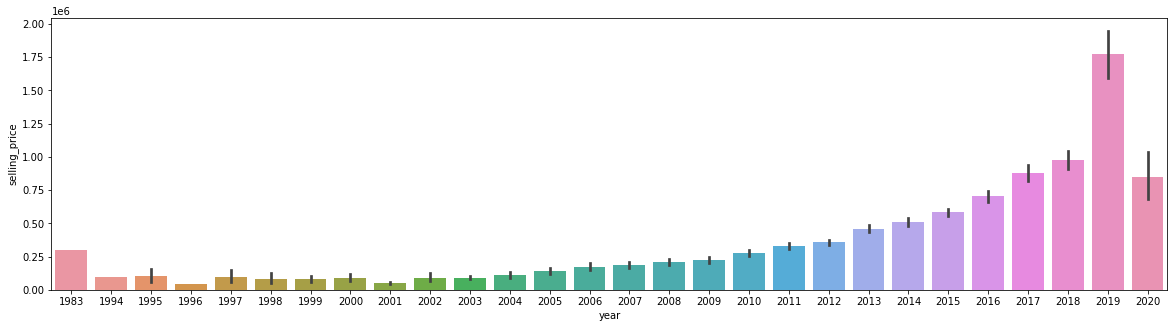

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot('year','selling_price',data=train)
plt.show()

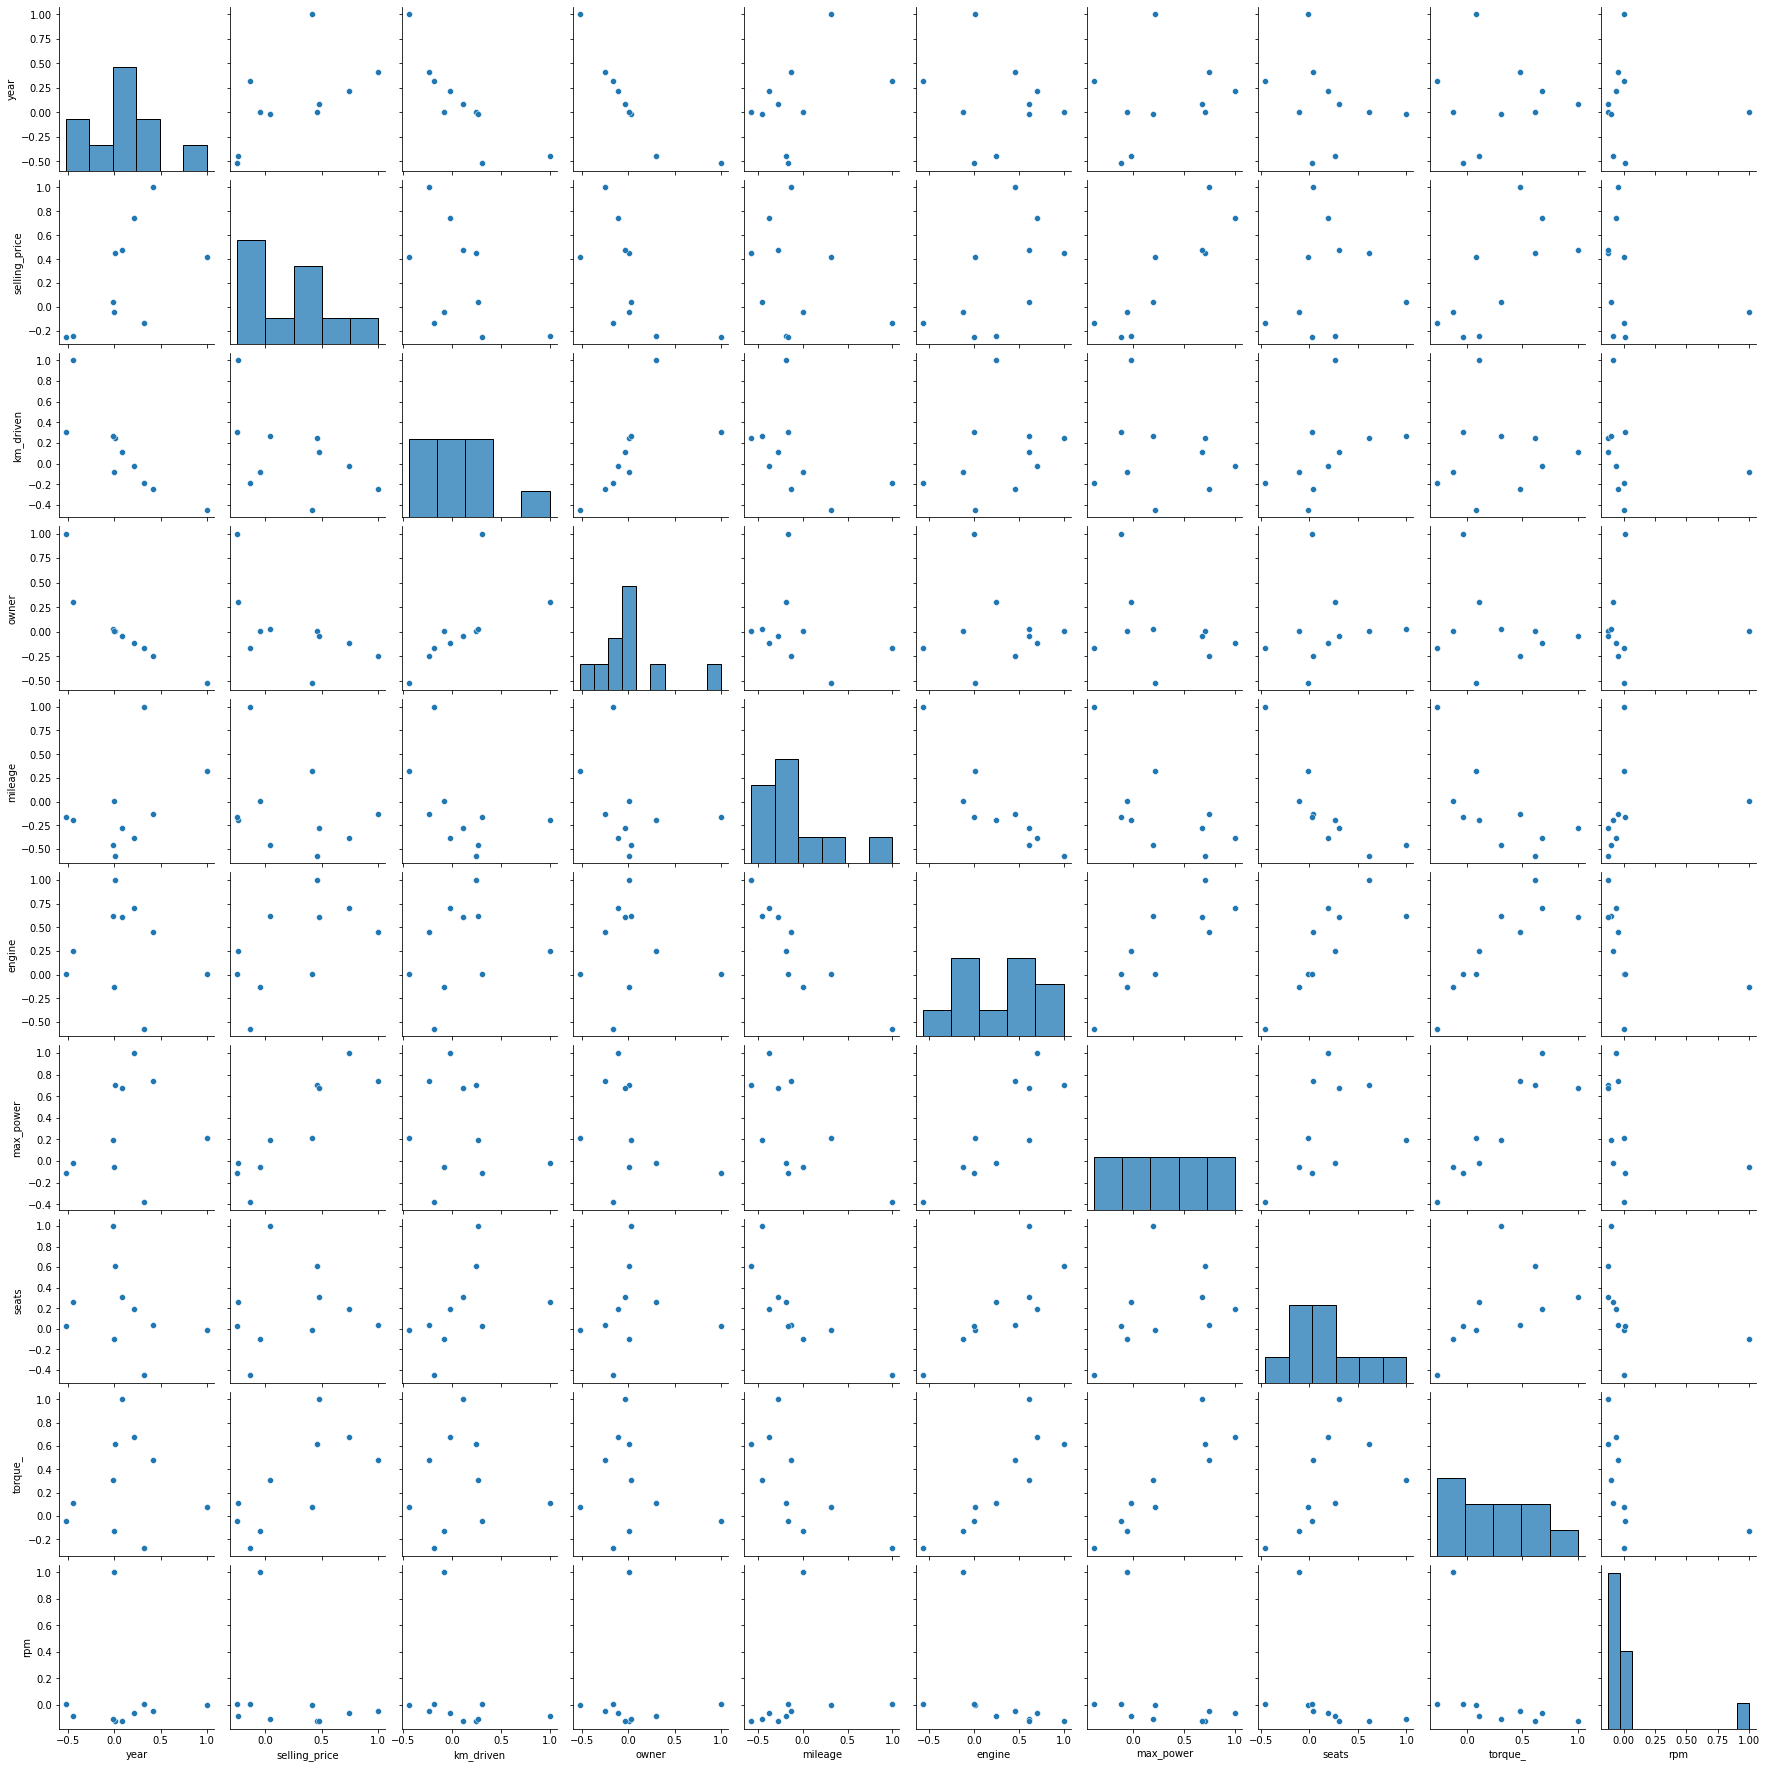

In [ ]:
sns.pairplot(train.corr())

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


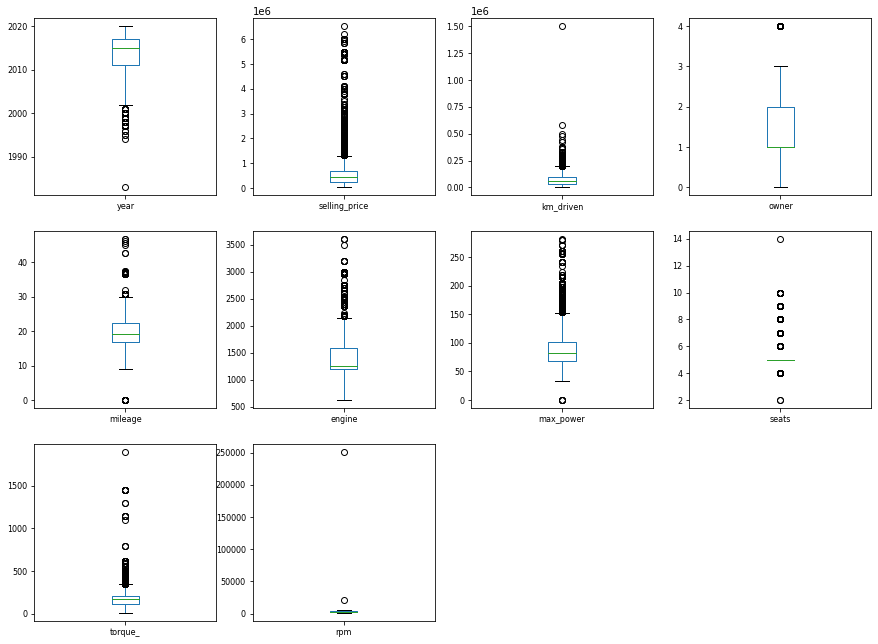

In [ ]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
train.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, fontsize=8, ax=ax)
plt.show()

In [ ]:
# train['seats'].fillna(train['seats'].mode()[0], inplace=True)
train.fillna(train.mode().iloc[0], inplace=True)
# test['seats'].fillna(train['seats'].mode()[0], inplace=True)
test.fillna(train.mode().iloc[0], inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


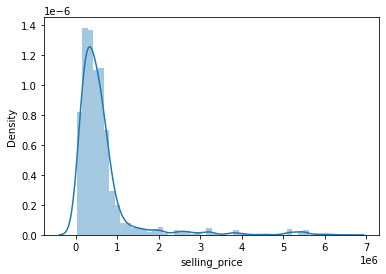

In [ ]:
sns.distplot(train.selling_price)

In [ ]:
# sns.distplot(np.log(train.selling_price), kde=False)

#Data prepare

In [ ]:
encoder = ce.TargetEncoder()
train['Company'] = encoder.fit_transform(train['Company'], train['selling_price'])
test['Company'] = encoder.transform(test['Company'])

In [ ]:
ColumsToConvert = [column for column in train.columns if train[column].dtype == 'O']
ColumsToConvert

['fuel', 'seller_type', 'transmission']

In [ ]:
def transform_col(df,Col):
    for i in Col:
        c = pd.get_dummies(df[i],prefix= i, drop_first =True)
        df = pd.concat ([df,c], axis = 1)
        df.drop(i , axis =1, inplace = True)

    return df 

train_data = transform_col(train,ColumsToConvert)
test_data = transform_col(test,ColumsToConvert)

In [ ]:
train_data.head(3)

,year,selling_price,km_driven,owner,mileage,engine,max_power,seats,Company,torque_,rpm,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,2018,850000,9500,1,21.50,1497.0,108.50,5.0,368927.489011,260.0,2125.0,1,0,0,1,0,1
1,2018,750000,30000,1,21.19,1396.0,88.76,5.0,454209.346228,219.7,2125.0,1,0,0,1,0,1
2,2015,1500000,80000,2,12.55,2982.0,168.50,7.0,951948.043716,360.0,2300.0,1,0,0,1,0,0


In [ ]:
test_data.head(3)

,Id,year,km_driven,owner,mileage,engine,max_power,seats,Company,torque_,rpm,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual
0,1,2016,11000,1,14.3,1598.0,103.5,5.0,635844.116883,153.0,3800.0,0,0,1,0,0,0
1,2,2017,35000,1,17.8,1497.0,117.3,5.0,595635.791045,145.0,4600.0,0,0,1,1,0,1
2,3,2014,80000,1,19.1,1197.0,82.0,5.0,454209.346228,114.0,4000.0,0,0,1,1,0,1


In [ ]:
print(train_data.shape)
print(test_data.shape)

(5999, 17)
(2128, 17)


In [ ]:
x_train = train_data.drop('selling_price' , axis =1)
y_train = train_data.iloc[:,1]
y_train = y_train.values
x_train = x_train.values

In [ ]:
x_test = test_data.drop("Id", axis =1)
y_test = test_data.iloc[:,0]
y_test = y_test.values
x_test = x_test.values

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [ ]:
Xtrain, Xval, Ytrain, Yval = train_test_split(X_train,y_train, test_size= 0.1, random_state=0)

#Model

r2 train: 0.9747746983328387 

{'reg_lambda': 0.15, 'reg_alpha': 0.02, 'num_leaves': 10, 'n_estimators': 270, 'learning_rate': 0.15}

r2 test: 0.986238980870279

In [ ]:
modelXGB = ltb.LGBMRegressor(reg_lambda= 0.15, reg_alpha= 0.02, num_leaves =10, n_estimators= 270, learning_rate= 0.15)
# (random_state=0,reg_lambda= 0.1, reg_alpha= 0.008, num_leaves= 11, n_estimators= 920, learning_rate= 0.15)

In [ ]:
parameters = {'n_estimators': range(700,1000, 5),
              "num_leaves": range(5,20,2),
              'learning_rate':[i/100 for i in range(10,20,1)],
              "reg_alpha": [i/1000 for i in range(5,11,1)],
              "reg_lambda":[i/100 for i in range(0,20,5)]
              }

In [ ]:
# modelXGB.get_params()

In [ ]:
# min = 100000
# for i in range(1,20):
#   print(f"Vòng thứ : {i} ")
#   xgb_grid = RandomizedSearchCV(modelXGB,
#                         parameters,
#                         cv = 5,
#                         verbose=3,scoring="r2",
#                        return_train_score=True)
#   xgb_grid.fit(Xtrain,Ytrain)
#   print(xgb_grid.best_score_)
#   print(xgb_grid.best_params_)
#   y4 = xgb_grid.predict(Xval)
#   m = mean_squared_error(Yval, y4, squared=False)

#   print(f"Vòng thứ : {i} có rmse: {rmse}\n\n")

#   if m<min:
#     min = m
#     model = xgb_grid 

# print("\n\n--------------------------\n")
# print(f"rmse:{min}")
# print(model.best_score_)
# print(model.best_params_)
# model.score(Xval,Yval)

In [ ]:
model = modelXGB.fit(Xtrain, Ytrain)

In [ ]:
y4 = model.predict(Xval)
mean_squared_error(Yval, y4, squared=False)

92497.0558933817

Text(0, 0.5, 'Predicted')

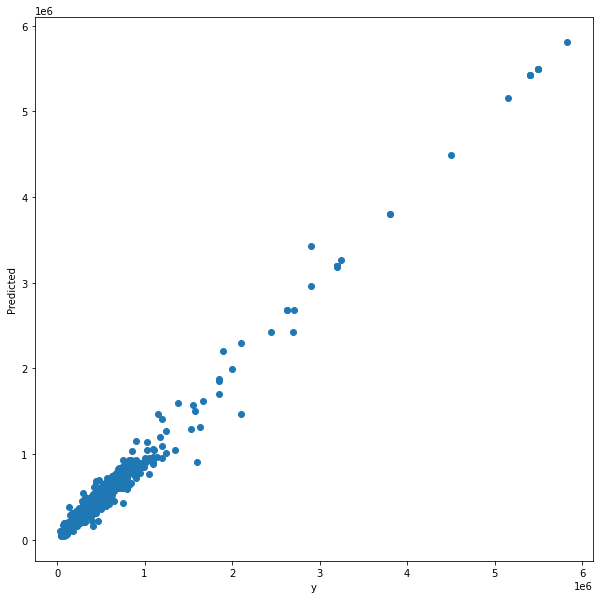

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(Yval,y4)
plt.xlabel('y')
plt.ylabel('Predicted')

In [ ]:
pre4 = model.predict(X_test)
resultxgb=pd.DataFrame({"Id":y_test,"Predicted":pre4})
resultxgb.to_csv("Car.csv",index=False)
r = pd.read_csv("/content/Car.csv")
r

,Id,Predicted
0,1,6.603024e+05
1,2,8.132334e+05
2,3,3.714284e+05
3,4,6.139656e+05
4,5,5.836527e+05
...,...,...
2123,2124,5.971737e+05
2124,2125,6.864205e+05
2125,2126,1.351921e+05
2126,2127,1.024262e+06


In [ ]:
a= pd.read_csv("/content/Car (4).csv")

In [ ]:
mean_squared_error(a.Predicted, r.Predicted, squared=False)

0.0